# i. Imports and load the data 

In [1]:
import re
from pathlib import Path
import os

from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, roc_auc_score
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import nfl_data_py as nfl

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

n_cores = os.cpu_count()

In [64]:
train_data_path = Path('../data/processed/field_goal_data.parquet')
fg_attempts = (
    pd.read_parquet(train_data_path)
    .assign(
        iced_kicker=lambda x: x['iced_kicker'].astype(int)
    )
)
fg_attempts.head()

,season,week,game_id,play_id,game_date,start_time,time_of_day,qtr,quarter_seconds_remaining,game_seconds_remaining,stadium,stadium_id,is_home,is_indoor,grass_surface,lighting_condition,posteam,defteam,posteam_score,defteam_score,score_differential,kicker_player_name,kicker_player_id,kicker_headshot_url,kicker_height,kicker_weight,kicker_years_exp,kicker_draft_number,kicker_age,kicker_rich_hill,temperature,chance_of_rain,snow_severity,wind_speed,wind_gust,yardline_100,tie_or_take_lead,to_stay_within_one_score,pressure_rating,iced_kicker,field_goal_result
0,2010,1,2010_01_GB_PHI,660.0,2010-09-12,"9/12/10, 16:15:46",2010-09-12T20:37:49Z,1.0,268.0,2968.0,Lincoln Financial Field,PHI00,1,0,1,0,PHI,GB,0.0,0.0,0.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.759,0.5,69.0,0.0,0,4.0,4.0,27.0,1,0,0.0,0,made
1,2010,1,2010_01_GB_PHI,3652.0,2010-09-12,"9/12/10, 16:15:46",2010-09-12T23:14:33Z,4.0,346.0,346.0,Lincoln Financial Field,PHI00,1,0,1,0,PHI,GB,17.0,27.0,-10.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.759,0.5,69.0,0.0,0,4.0,4.0,5.0,0,1,1.0,0,made
2,2010,4,2010_04_WAS_PHI,865.0,2010-10-03,"10/3/10, 16:15:32",2010-10-03T20:54:58Z,2.0,900.0,2700.0,Lincoln Financial Field,PHI00,1,0,1,0,PHI,WAS,0.0,14.0,-14.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.817,0.5,63.0,0.0,0,13.0,13.0,31.0,0,0,0.0,0,made
3,2010,4,2010_04_WAS_PHI,1680.0,2010-10-03,"10/3/10, 16:15:32",2010-10-03T21:35:05Z,2.0,23.0,1823.0,Lincoln Financial Field,PHI00,1,0,1,0,PHI,WAS,3.0,17.0,-14.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.817,0.5,63.0,0.0,0,13.0,13.0,6.0,0,0,0.0,0,made
4,2010,5,2010_05_PHI_SF,986.0,2010-10-10,"10/10/10, 20:30:42",2010-10-11T01:09:05Z,2.0,705.0,2505.0,Candlestick Park,SFO00,-1,0,1,2,PHI,SF,7.0,7.0,0.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.836,0.5,71.0,0.0,0,10.0,10.0,14.0,1,0,0.0,0,made


In [3]:
fg_attempts.field_goal_result.value_counts(normalize=False)

made       13466
missed      2190
blocked      315
Name: field_goal_result, dtype: int64

# ii. Blocked field goals
Will not include these in the FG Make probability model, as it could add noise when trying to learn kicker skill. Blocks could be partially due to a kickers low launch angle, variance wiht a defender getting lucky with hand placement, or a poor block. Two of the three of those are out of the kickers control.

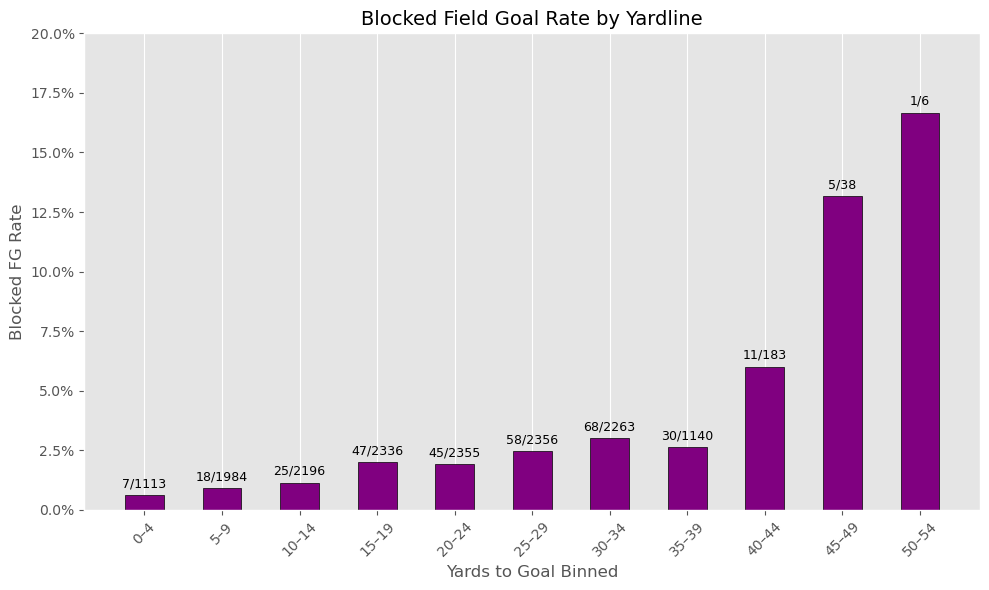

In [4]:
cpy = fg_attempts[['yardline_100', 'field_goal_result']].copy()

# Bin yardlines into 5-yard intervals
bins = np.arange(0, 60, 5)
cpy['yardline_bin'] = pd.cut(cpy['yardline_100'], bins=bins, right=False)

# Count total FG attempts and blocked FGs per bin
bin_totals = cpy.groupby('yardline_bin').size()
blocked_counts = cpy.query('field_goal_result == "blocked"').groupby('yardline_bin').size()

# Fill missing blocked counts with 0 for bins with no blocked FGs
blocked_counts = blocked_counts.reindex(bin_totals.index, fill_value=0)

# Calculate blocked rate
blocked_rate = blocked_counts / bin_totals

# Plot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

bar_container = ax.bar(
    range(len(blocked_rate)), 
    blocked_rate.values, 
    width=0.5, 
    color='purple', 
    edgecolor='black'
)

# Add fraction labels on top of each bar
for i, (blocked, total, bar) in enumerate(zip(blocked_counts.values, bin_totals.values, bar_container)):
    label = f'{int(blocked)}/{int(total)}'
    ax.text(bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.002, 
            label, 
            ha='center', va='bottom', fontsize=9)

# Set custom x-axis labels
bin_labels = [f'{int(interval.left)}–{int(interval.right - 1)}' for interval in blocked_rate.index]
ax.set_xticks(range(len(bin_labels)))
ax.set_xticklabels(bin_labels, rotation=45)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.1f}%'))

ax.set_title('Blocked Field Goal Rate by Yardline', fontsize=14)
ax.set_xlabel('Yards to Goal Binned')
ax.set_ylabel('Blocked FG Rate')
ax.set_ylim(0, blocked_rate.max() * 1.2)
ax.grid(axis='y')
plt.tight_layout()
plt.show()


# ii. FG Make Probability Model

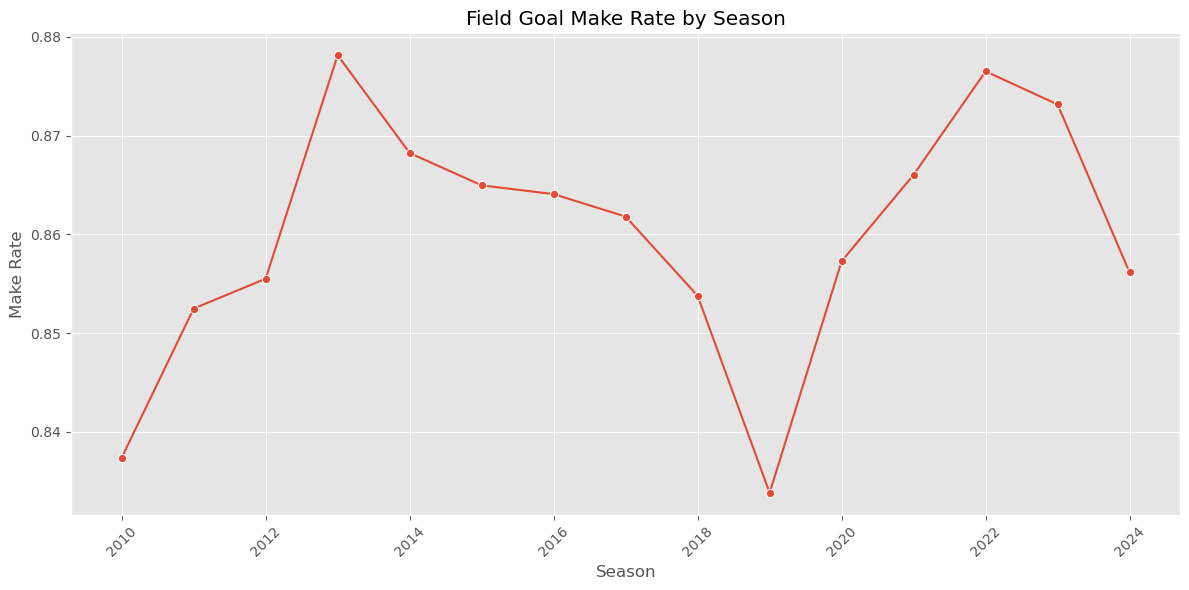

In [5]:
# plot the fg make rate by season
fg_make_rate = fg_attempts.groupby('season').field_goal_result.value_counts(normalize=True).unstack().fillna(0)
fg_make_rate['make_rate'] = fg_make_rate['made'] / (fg_make_rate['made'] + fg_make_rate['missed'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=fg_make_rate, x='season', y='make_rate', marker='o')
plt.title('Field Goal Make Rate by Season')
plt.xlabel('Season')
plt.ylabel('Make Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

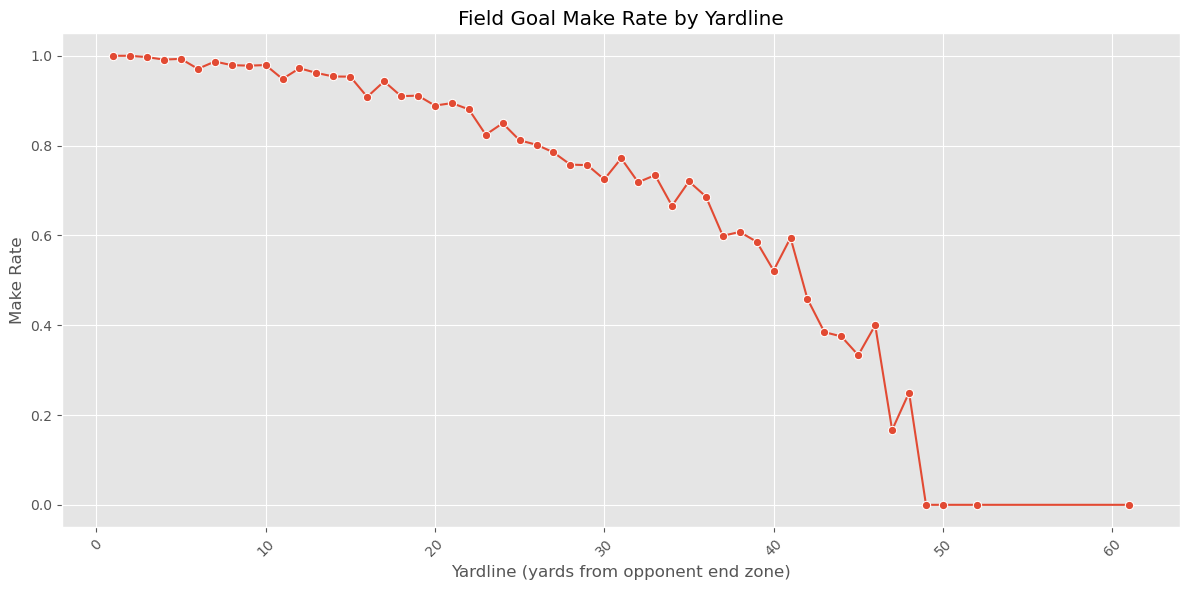

In [6]:
# plot fg make rate by yardline
fg_make_rate_yardline = fg_attempts.groupby('yardline_100').field_goal_result.value_counts(normalize=True).unstack().fillna(0)
fg_make_rate_yardline['make_rate'] = fg_make_rate_yardline['made'] / (fg_make_rate_yardline['made'] + fg_make_rate_yardline['missed'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=fg_make_rate_yardline, x='yardline_100', y='make_rate', marker='o')
plt.title('Field Goal Make Rate by Yardline')
plt.xlabel('Yardline (yards from opponent end zone)')
plt.ylabel('Make Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show() 

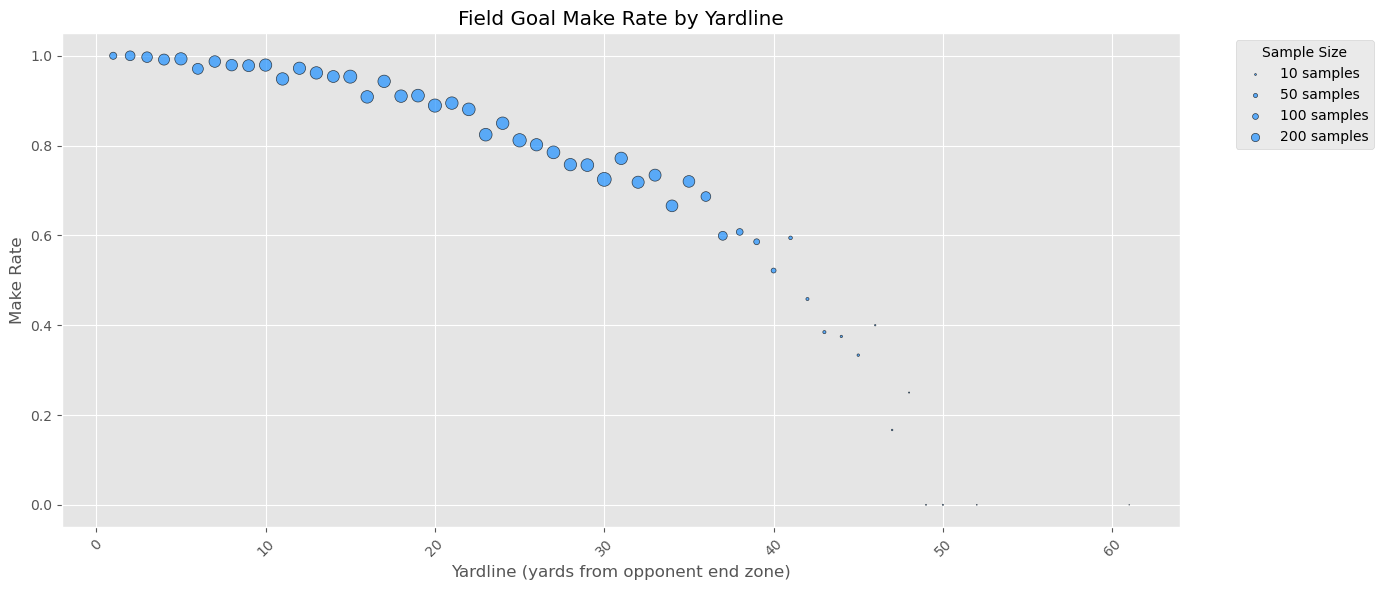

In [7]:
# Plot FG make rate by yardline, with marker size proportional to sample size and a legend for sample sizes

fg_make_rate_yardline = (
    fg_attempts.groupby('yardline_100').field_goal_result.value_counts(normalize=True)
    .unstack().fillna(0)
)
fg_make_rate_yardline['make_rate'] = fg_make_rate_yardline['made'] / (
    fg_make_rate_yardline['made'] + fg_make_rate_yardline['missed']
)
fg_make_rate_yardline['sample_size'] = (
    fg_attempts.groupby('yardline_100').size()
)

plt.figure(figsize=(12, 6))
sizes = fg_make_rate_yardline['sample_size']
# Normalize sizes for plotting (adjust scale as needed)
size_scale = 100
marker_sizes = size_scale * (sizes / sizes.max())

scatter = plt.scatter(
    fg_make_rate_yardline.index,
    fg_make_rate_yardline['make_rate'],
    s=marker_sizes,
    alpha=0.7,
    c='dodgerblue',
    edgecolor='black',
    label='FG Make Rate'
)

plt.title('Field Goal Make Rate by Yardline')
plt.xlabel('Yardline (yards from opponent end zone)')
plt.ylabel('Make Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Create a legend for sample sizes
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Choose representative sample sizes for legend
legend_sizes = [10, 50, 100, 200]
handles = [
    plt.scatter([], [], s=size_scale * (n / sizes.max()), color='dodgerblue', edgecolor='black', alpha=0.7,
                label=f'{n} samples')
    for n in legend_sizes
]
plt.legend(handles=handles, title='Sample Size', loc='upper right', bbox_to_anchor=(1.18, 1))

plt.show()

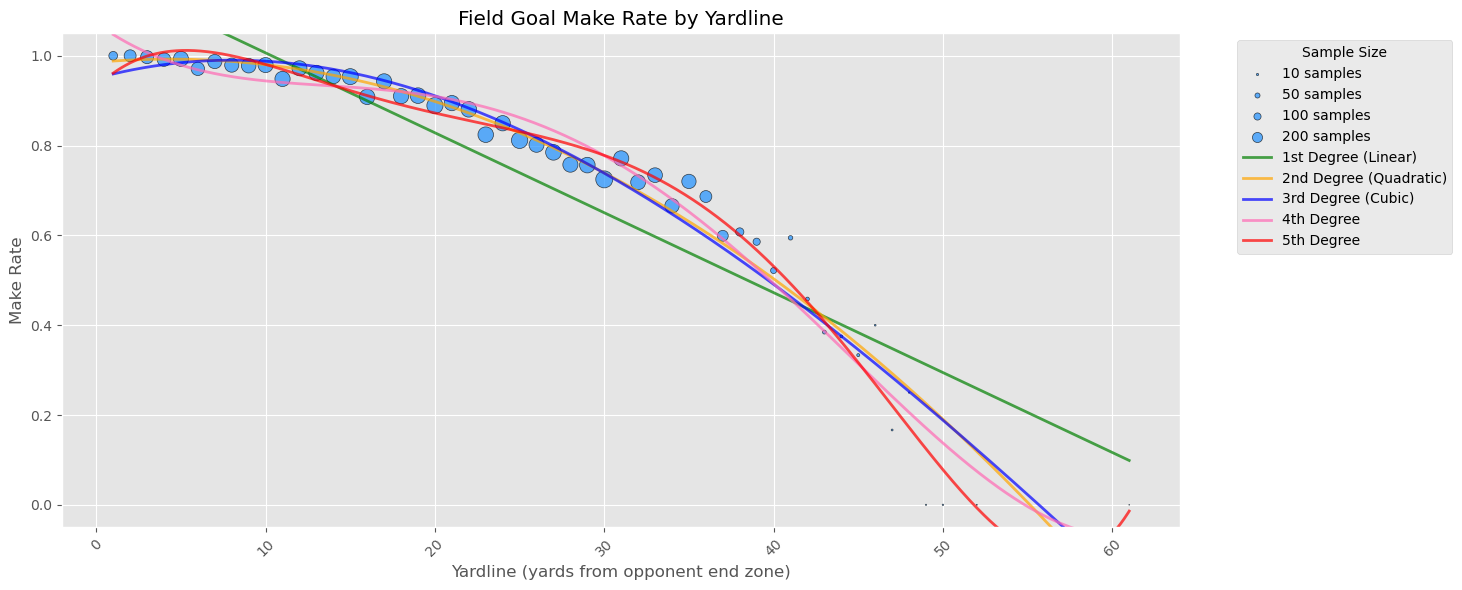

In [8]:
fg_make_rate_yardline = (
    fg_attempts.groupby('yardline_100').field_goal_result.value_counts(normalize=True)
    .unstack().fillna(0)
)
fg_make_rate_yardline['make_rate'] = fg_make_rate_yardline['made'] / (
    fg_make_rate_yardline['made'] + fg_make_rate_yardline['missed']
)
fg_make_rate_yardline['sample_size'] = (
    fg_attempts.groupby('yardline_100').size()
)

plt.figure(figsize=(12, 6))
sizes = fg_make_rate_yardline['sample_size']
size_scale = 150
marker_sizes = size_scale * (sizes / sizes.max())

scatter = plt.scatter(
    fg_make_rate_yardline.index,
    fg_make_rate_yardline['make_rate'],
    s=marker_sizes,
    alpha=0.7,
    c='dodgerblue',
    edgecolor='black',
    label='FG Make Rate'
)

x = np.array(fg_make_rate_yardline.index)
y = fg_make_rate_yardline['make_rate'].values
x_fit = np.linspace(x.min(), x.max(), 1000)

# Fit and plot polynomials of degree 1 to 5
colors = ['green', 'orange', 'blue', 'hotpink', 'red']
labels = [
    '1st Degree (Linear)',
    '2nd Degree (Quadratic)',
    '3rd Degree (Cubic)',
    '4th Degree',
    '5th Degree'
]
for deg, color, label in zip(range(1, 6), colors, labels):
    coeffs = np.polyfit(x, y, deg)
    poly = np.poly1d(coeffs)
    y_fit = poly(x_fit)
    plt.plot(x_fit, y_fit, color=color, linewidth=2, label=label, alpha=0.7)

plt.title('Field Goal Make Rate by Yardline')
plt.xlabel('Yardline (yards from opponent end zone)')
plt.ylabel('Make Rate')
plt.ylim(-.05, 1.05)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

import matplotlib.lines as mlines
legend_sizes = [10, 50, 100, 200]
handles = [
    plt.scatter([], [], s=size_scale * (n / sizes.max()), color='dodgerblue', edgecolor='black', alpha=0.7,
                label=f'{n} samples')
    for n in legend_sizes
]
# Add polynomial lines to legend
for color, label in zip(colors, labels):
    handles.append(mlines.Line2D([], [], color=color, linewidth=2, label=label, alpha=0.7))
plt.legend(handles=handles, title='Sample Size', loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

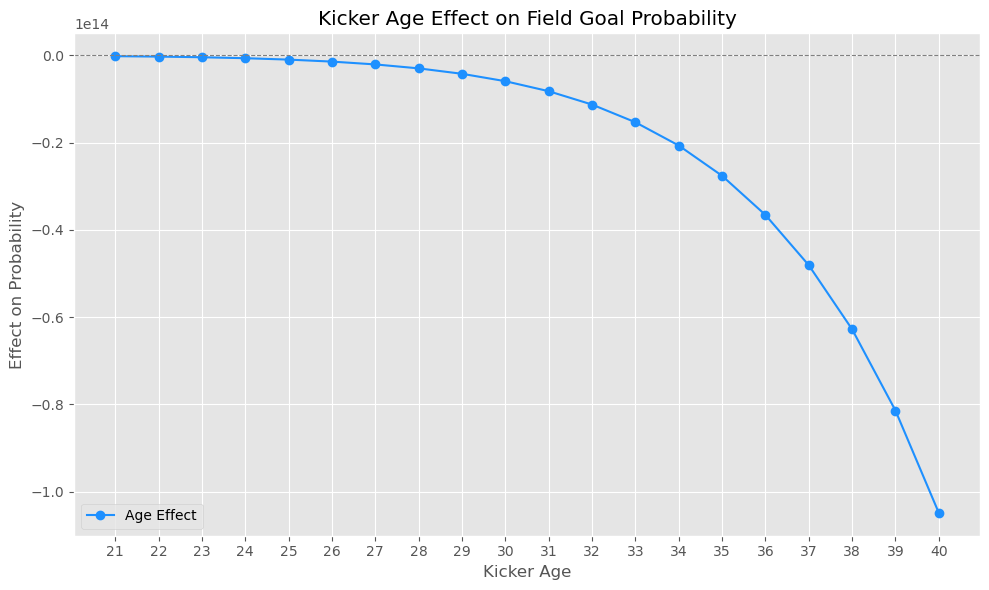

In [96]:
# plot this from ages 21-40: y = .1 * age - .05 * age^10
ages = np.arange(21, 41)
age_effect = 0.08 * ages - 0.01 * (ages **10)    
plt.figure(figsize=(10, 6))
plt.plot(ages, age_effect, marker='o', color='dodgerblue', label='Age Effect')
plt.title('Kicker Age Effect on Field Goal Probability')
plt.xlabel('Kicker Age')
plt.ylabel('Effect on Probability')
plt.xticks(ages)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
def evaluate_model(model, trace, y, coefficients):
    # Get posterior predictive samples
    with model:
        pp_samples = pm.sample_posterior_predictive(trace, var_names=['p'])

    # Calculate mean predicted probability across samples
    mean_p = pp_samples['posterior_predictive']['p'].mean(axis=1).mean(axis=0)

    # 1. Brier Score (lower is better)
    brier = brier_score_loss(y, mean_p)
    print(f"Brier Score: {brier:.4f}")

    # 2. AUC-ROC (higher is better, 0.5 = random)
    auc = roc_auc_score(y, mean_p)
    print(f"AUC-ROC: {auc:.4f}")

    # 3. LOOIC (from ArviZ)
    loo = az.loo(trace, pointwise=True)
    print("\nLOOIC Summary:")
    print(loo)

    # 4. Additional diagnostics
    print("\nModel Diagnostics:")
    print(az.summary(trace, var_names=coefficients,
                    kind='stats', round_to=2))

    # 5. Calibration check (expected vs actual)
    print("\nCalibration by Decile:")
    calibration_df = pd.DataFrame({'pred': mean_p, 'actual': y})
    calibration_df['decile'] = pd.qcut(calibration_df['pred'], q=10, duplicates='drop')
    print(calibration_df.groupby('decile').agg(actual_mean=('actual', 'mean'),
                                            pred_mean=('pred', 'mean'),
                                            count=('pred', 'count')))

In [65]:
fg_attempts.head()

,season,week,game_id,play_id,game_date,start_time,time_of_day,qtr,quarter_seconds_remaining,game_seconds_remaining,stadium,stadium_id,is_home,is_indoor,grass_surface,lighting_condition,posteam,defteam,posteam_score,defteam_score,score_differential,kicker_player_name,kicker_player_id,kicker_headshot_url,kicker_height,kicker_weight,kicker_years_exp,kicker_draft_number,kicker_age,kicker_rich_hill,temperature,chance_of_rain,snow_severity,wind_speed,wind_gust,yardline_100,tie_or_take_lead,to_stay_within_one_score,pressure_rating,iced_kicker,field_goal_result
0,2010,1,2010_01_GB_PHI,660.0,2010-09-12,"9/12/10, 16:15:46",2010-09-12T20:37:49Z,1.0,268.0,2968.0,Lincoln Financial Field,PHI00,1,0,1,0,PHI,GB,0.0,0.0,0.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.759,0.5,69.0,0.0,0,4.0,4.0,27.0,1,0,0.0,0,made
1,2010,1,2010_01_GB_PHI,3652.0,2010-09-12,"9/12/10, 16:15:46",2010-09-12T23:14:33Z,4.0,346.0,346.0,Lincoln Financial Field,PHI00,1,0,1,0,PHI,GB,17.0,27.0,-10.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.759,0.5,69.0,0.0,0,4.0,4.0,5.0,0,1,1.0,0,made
2,2010,4,2010_04_WAS_PHI,865.0,2010-10-03,"10/3/10, 16:15:32",2010-10-03T20:54:58Z,2.0,900.0,2700.0,Lincoln Financial Field,PHI00,1,0,1,0,PHI,WAS,0.0,14.0,-14.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.817,0.5,63.0,0.0,0,13.0,13.0,31.0,0,0,0.0,0,made
3,2010,4,2010_04_WAS_PHI,1680.0,2010-10-03,"10/3/10, 16:15:32",2010-10-03T21:35:05Z,2.0,23.0,1823.0,Lincoln Financial Field,PHI00,1,0,1,0,PHI,WAS,3.0,17.0,-14.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.817,0.5,63.0,0.0,0,13.0,13.0,6.0,0,0,0.0,0,made
4,2010,5,2010_05_PHI_SF,986.0,2010-10-10,"10/10/10, 20:30:42",2010-10-11T01:09:05Z,2.0,705.0,2505.0,Candlestick Park,SFO00,-1,0,1,2,PHI,SF,7.0,7.0,0.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.836,0.5,71.0,0.0,0,10.0,10.0,14.0,1,0,0.0,0,made


In [109]:
dataset = (
    fg_attempts
    .query('field_goal_result.isin(["made", "missed"])')
    .copy()
    .query('2010 <= season <= 2024 ') # limit to 4 seasons to speed up sampling
)

scaler = StandardScaler()

# Kickers
kicker_ids, kicker_idx = np.unique(dataset["kicker_player_id"], return_inverse=True)
print(f"Number of unique kickers: {len(kicker_ids)}")

# Age & Rich Hill Score
kicker_age = scaler.fit_transform(dataset[["kicker_age"]].values).flatten()
kicker_age_poly = scaler.fit_transform((dataset[["kicker_age"]].values ** 10)).flatten()
kicker_rich_hill = scaler.fit_transform((dataset[["kicker_rich_hill"]].values)).flatten()

# Situational Features
yards_to_goal = scaler.fit_transform((dataset[['yardline_100']].values)).flatten()
yards_to_goal_poly = scaler.fit_transform((dataset[['yardline_100']].values ** 2)).flatten()
pressure_rating = scaler.fit_transform((dataset[['pressure_rating']].values)).flatten()
iced_kicker = scaler.fit_transform((dataset[['iced_kicker']].values)).flatten()
lighting_time_of_day = scaler.fit_transform((dataset[['lighting_condition']].values)).flatten()
tie_or_take_lead = scaler.fit_transform((dataset[['tie_or_take_lead']].values)).flatten()

# Location
is_home_team = scaler.fit_transform((dataset['is_home'].values.reshape(-1,1))).flatten()
is_grass_surface = scaler.fit_transform(dataset['grass_surface'].values.reshape(-1,1)).flatten()
# is_denver_stadium = scaler.fit_transform(dataset.stadium.eq('Empower Field at Mile High').astype(int).values.reshape(-1, 1)).flatten()
stadium_ids, stadium_idx = np.unique(dataset['stadium_id'], return_inverse=True)
print(f"Number of unique stadiums: {len(stadium_ids)}")

# Weather
temperature = scaler.fit_transform((dataset[['temperature']].values)).flatten()
chance_of_rain = scaler.fit_transform((dataset[['chance_of_rain']].values)).flatten()
snow_severity = scaler.fit_transform((dataset[['snow_severity']].values)).flatten()
wind_speed = scaler.fit_transform((dataset[['wind_speed']].values)).flatten()
wind_gust = scaler.fit_transform((dataset[['wind_gust']].values)).flatten()

# Season
season = scaler.fit_transform(dataset[['season']].values).flatten()

# Response Variable
y = dataset['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0).values

with pm.Model() as hierarchical_kicker_model:
    # Global intercept and betas
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta_ytg = pm.Normal("beta_ytg", mu=-1, sigma=1)
    beta_ytg2 = pm.Normal("beta_ytg2", mu=-1, sigma=1)
    beta_season = pm.Normal("beta_season", mu=0, sigma=1)
    beta_age = pm.Normal("beta_age", mu=0, sigma=1)
    beta_age_poly = pm.Normal("beta_age_poly", mu=0, sigma=1)
    beta_pressure_rating = pm.Normal("beta_pressure_rating", mu=0, sigma=1)
    beta_iced_kicker = pm.Normal("beta_iced_kicker", mu=0, sigma=1)
    beta_lighting_time_of_day = pm.Normal("beta_lighting_time_of_day", mu=0, sigma=1)
    beta_is_home_team = pm.Normal("beta_is_home_team", mu=0, sigma=1)
    beta_is_grass_surface = pm.Normal("beta_is_grass_surface", mu=0, sigma=1)
    beta_temperature = pm.Normal("beta_temperature", mu=0, sigma=1)
    beta_chance_of_rain = pm.Normal("beta_chance_of_rain", mu=0, sigma=1)
    beta_snow_severity = pm.Normal("beta_snow_severity", mu=0, sigma=1)
    beta_wind_speed = pm.Normal("beta_wind_speed", mu=0, sigma=1)
    beta_wind_gust = pm.Normal("beta_wind_gust", mu=0, sigma=1)
    beta_tie_or_take_lead = pm.Normal("beta_tie_or_take_lead", mu=0, sigma=1)
    # beta_is_denver_stadium = pm.Normal("beta_is_denver_stadium", mu=0, sigma=1)

   # Kicker-specific slope for yards_to_goal (leg strength proxy)
    mu_kicker_ytg = pm.Normal("mu_kicker_ytg", mu=0, sigma=1)
    sigma_kicker_ytg = pm.Exponential("sigma_kicker_ytg", 1.0)
    kicker_intercepts = pm.Normal("kicker_intercepts", mu=mu_kicker_ytg, sigma=sigma_kicker_ytg, shape=len(kicker_ids))
    kicker_ytg_slopes = pm.Normal("kicker_ytg_slopes", mu=mu_kicker_ytg, sigma=sigma_kicker_ytg, shape=len(kicker_ids))

    # Kicker skill prior informed by rich hill proxy
    beta_richhill = pm.Normal("beta_richhill", mu=0, sigma=1)

    # Stadium-specific intercepts
    mu_stadium = pm.Normal("mu_stadium", mu=0, sigma=1)
    sigma_stadium = pm.Exponential("sigma_stadium", 1.0)
    stadium_intercepts = pm.Normal("stadium_intercepts", mu=mu_stadium, sigma=sigma_stadium, shape=len(stadium_ids))
    
    # Model equation
    logit_p = (
        alpha
        + kicker_intercepts[kicker_idx]                  # Accuracy
        + kicker_ytg_slopes[kicker_idx] * yards_to_goal  # Leg strength
        + beta_ytg2 * yards_to_goal_poly 
        + beta_richhill * kicker_rich_hill
        + beta_age * kicker_age
        + beta_age_poly * kicker_age_poly
        + beta_season * season
        + beta_pressure_rating * pressure_rating
        + beta_iced_kicker * iced_kicker
        + beta_lighting_time_of_day * lighting_time_of_day
        + beta_is_home_team * is_home_team
        + beta_is_grass_surface * is_grass_surface
        + beta_temperature * temperature
        + beta_chance_of_rain * chance_of_rain
        + beta_snow_severity * snow_severity
        + beta_wind_speed * wind_speed
        + beta_wind_gust * wind_gust
        + stadium_intercepts[stadium_idx]                # Stadium effect
        + beta_tie_or_take_lead * tie_or_take_lead       # Tie or take lead effect
        # + beta_is_denver_stadium * is_denver_stadium      # Denver stadium effect
    )
    
    # Likelihood
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Sample
    trace_hier = pm.sample(
        draws=1500,
        return_inferencedata=True,
        idata_kwargs={'log_likelihood': True},
        cores=n_cores,
        progressbar=True
    )

evaluate_model(hierarchical_kicker_model, trace_hier, y,  
    ['alpha', 'beta_ytg', 'beta_ytg2', 'beta_season', 'beta_age', 'beta_age_poly', 
    'beta_richhill', 'kicker_intercepts', 'kicker_ytg_slopes',
    'beta_pressure_rating', 'beta_iced_kicker',
    'beta_lighting_time_of_day', 'beta_is_home_team', 'beta_is_grass_surface',
    'beta_temperature', 'beta_chance_of_rain', 'beta_snow_severity', 'beta_wind_speed', 'beta_wind_gust',
    'stadium_intercepts', 'beta_tie_or_take_lead'] #'beta_is_denver_stadium']
)

Number of unique kickers: 134
Number of unique stadiums: 47


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, beta_ytg, beta_ytg2, beta_season, beta_age, beta_age_poly, beta_pressure_rating, beta_iced_kicker, beta_lighting_time_of_day, beta_is_home_team, beta_is_grass_surface, beta_temperature, beta_chance_of_rain, beta_snow_severity, beta_wind_speed, beta_wind_gust, beta_tie_or_take_lead, mu_kicker_ytg, sigma_kicker_ytg, kicker_intercepts, kicker_ytg_slopes, beta_richhill, mu_stadium, sigma_stadium, stadium_intercepts]


Output()

Sampling 8 chains for 1_000 tune and 1_500 draw iterations (8_000 + 12_000 draws total) took 1731 seconds.
There were 2195 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: []


Output()

Brier Score: 0.1041
AUC-ROC: 0.7865

LOOIC Summary:
Computed from 12000 posterior samples and 15656 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5349.29    72.54
p_loo       68.96        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     15656  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%


Model Diagnostics:
                           mean    sd  hdi_3%  hdi_97%
alpha                      3.74  0.93    2.17     5.47
beta_ytg                  -1.02  1.03   -3.20     0.66
beta_ytg2                  0.53  0.11    0.31     0.75
beta_season                0.11  0.03    0.06     0.17
beta_age                   0.14  0.04    0.06     0.21
beta_age_poly             -0.11  0.04   -0.19    -0.04
beta_richhill             -0.01  0.03   -0.07     0.05
kicker_intercepts[0]      -1.88  0.18   -2.26    -1.55
kicker_intercepts[1]      -1.83  0.19   -2.20    -1.47
kicker_intercepts[

In [110]:
kicker_intercept_df = pd.DataFrame({
    'kicker_id': kicker_ids,
    'kicker_intercept': trace_hier.posterior['kicker_intercepts'].mean(dim=('chain', 'draw')),
}).merge(
    dataset[['kicker_player_id', 'kicker_player_name']].drop_duplicates(),
    left_on='kicker_id',
    right_on='kicker_player_id',
    how='left'
).drop(columns='kicker_player_id')
kicker_intercept_df.sort_values('kicker_intercept', ascending=False, inplace=True, ignore_index=True)
kicker_intercept_df

,kicker_id,kicker_intercept,kicker_player_name
0,00-0029597,-1.557350,Justin Tucker
1,00-0031136,-1.691879,Chris Boswell
2,00-0037224,-1.712186,Cameron Dicker
3,00-0020578,-1.716838,Matt Bryant
4,00-0033303,-1.720831,Harrison Butker
5,00-0016919,-1.721955,Adam Vinatieri
6,00-0025944,-1.722345,Steven Hauschka
7,00-0026138,-1.734028,Connor Barth
8,00-0037692,-1.736178,Brandon Aubrey
9,00-0034794,-1.738003,Jason Sanders


In [111]:
kicker_leg_df = pd.DataFrame({
    'kicker_id': kicker_ids,
    'kicker_ytg_slopes': trace_hier.posterior['kicker_ytg_slopes'].mean(dim=('chain', 'draw')),
}).merge(
    dataset[['kicker_player_id', 'kicker_player_name']].drop_duplicates(),
    left_on='kicker_id',
    right_on='kicker_player_id',
    how='left'
).drop(columns='kicker_player_id')
kicker_leg_df.sort_values('kicker_ytg_slopes', ascending=False, inplace=True, ignore_index=True)
kicker_leg_df

,kicker_id,kicker_ytg_slopes,kicker_player_name
0,00-0016919,-1.669275,Adam Vinatieri
1,00-0037692,-1.702408,Brandon Aubrey
2,00-0026858,-1.723973,Graham Gano
3,00-0004091,-1.725716,Phil Dawson
4,00-0025824,-1.733274,Garrett Hartley
5,00-0031136,-1.733360,Chris Boswell
6,00-0020578,-1.733556,Matt Bryant
7,00-0033303,-1.736658,Harrison Butker
8,00-0036162,-1.740942,Tyler Bass
9,00-0037224,-1.745325,Cameron Dicker


In [113]:
# evaluate the stadiums
stadium_intercept_df = pd.DataFrame({
    'stadium_id': stadium_ids,
    'stadium_intercept': trace_hier.posterior['stadium_intercepts'].mean(dim=('chain', 'draw')),
}).merge(
    dataset[['stadium_id', 'stadium']].drop_duplicates(),
    left_on='stadium_id',
    right_on='stadium_id',
    how='left'
).drop(columns='stadium_id')
stadium_intercept_df.sort_values('stadium_intercept', ascending=False, inplace=True, ignore_index=True)
stadium_intercept_df

,stadium_intercept,stadium
0,0.555242,EverBank Stadium
1,0.544387,Bank of America Stadium
2,0.538508,Nissan Stadium
3,0.525968,AT&T Stadium
4,0.514223,Empower Field at Mile High
5,0.508444,M&T Bank Stadium
6,0.503207,Mercedes-Benz Stadium
7,0.503063,Allegiant Stadium
8,0.493945,Levi's® Stadium
9,0.491767,Mall of America Field


In [122]:
# define replacement level kicker features (20th percentile of feature range)
age = round(fg_attempts.drop_duplicates(subset='kicker_player_id').kicker_age.quantile(0.2), 3)
replacement_kicker_features = {
    'kicker_age': age,
    'kicker_age_poly': age ** 10,
    'kicker_rich_hill': fg_attempts.drop_duplicates(subset='kicker_player_id').kicker_rich_hill.quantile(0.2),
    'kicker_intercept': kicker_intercept_df.kicker_intercept.quantile(0.2),
    'kicker_ytg_slopes': kicker_leg_df.kicker_ytg_slopes.quantile(0.2),
}

# iii. Field Goal Over Replacement (FGOR) Calculations

In [123]:
def predict_fg_probability(data, trace, scaler, kicker_ids, stadium_ids, replacement_features=None):
    """
    Make predictions using the hierarchical kicker model
    
    Parameters:
    - data: DataFrame with the same features as the training data
    - trace: PyMC trace object
    - scaler: StandardScaler fitted on training data
    - kicker_ids: Array of kicker IDs from training
    - stadium_ids: Array of stadium IDs from training
    - replacement_features: Dict with replacement kicker features (optional)
    """
    
    # Create kicker and stadium indices
    kicker_idx = np.array([np.where(kicker_ids == kid)[0][0] if kid in kicker_ids else -1 
                          for kid in data['kicker_player_id']])
    stadium_idx = np.array([np.where(stadium_ids == sid)[0][0] if sid in stadium_ids else -1 
                           for sid in data['stadium_id']])
    
    # Handle unknown kickers/stadiums by using mean values
    unknown_kicker_mask = kicker_idx == -1
    unknown_stadium_mask = stadium_idx == -1
    
    # Get mean coefficients from trace
    alpha_mean = trace.posterior['alpha'].mean().values
    beta_ytg_mean = trace.posterior['beta_ytg'].mean().values
    beta_ytg2_mean = trace.posterior['beta_ytg2'].mean().values
    beta_season_mean = trace.posterior['beta_season'].mean().values
    beta_age_mean = trace.posterior['beta_age'].mean().values
    beta_age_poly_mean = trace.posterior['beta_age_poly'].mean().values
    beta_richhill_mean = trace.posterior['beta_richhill'].mean().values
    beta_pressure_rating_mean = trace.posterior['beta_pressure_rating'].mean().values
    beta_iced_kicker_mean = trace.posterior['beta_iced_kicker'].mean().values
    beta_lighting_time_of_day_mean = trace.posterior['beta_lighting_time_of_day'].mean().values
    beta_is_home_team_mean = trace.posterior['beta_is_home_team'].mean().values
    beta_is_grass_surface_mean = trace.posterior['beta_is_grass_surface'].mean().values
    beta_temperature_mean = trace.posterior['beta_temperature'].mean().values
    beta_chance_of_rain_mean = trace.posterior['beta_chance_of_rain'].mean().values
    beta_snow_severity_mean = trace.posterior['beta_snow_severity'].mean().values
    beta_wind_speed_mean = trace.posterior['beta_wind_speed'].mean().values
    beta_wind_gust_mean = trace.posterior['beta_wind_gust'].mean().values
    beta_tie_or_take_lead_mean = trace.posterior['beta_tie_or_take_lead'].mean().values
    
    # Kicker and stadium coefficients
    kicker_intercepts_mean = trace.posterior['kicker_intercepts'].mean(dim=('chain', 'draw')).values
    kicker_ytg_slopes_mean = trace.posterior['kicker_ytg_slopes'].mean(dim=('chain', 'draw')).values
    stadium_intercepts_mean = trace.posterior['stadium_intercepts'].mean(dim=('chain', 'draw')).values
    
    # Scale the features using the same scaler
    kicker_age_scaled = scaler.transform(data[['kicker_age']].values).flatten()
    kicker_age_poly_scaled = scaler.transform((data[['kicker_age']].values ** 10)).flatten()
    kicker_rich_hill_scaled = scaler.transform(data[['kicker_rich_hill']].values).flatten()
    
    yards_to_goal_scaled = scaler.transform(data[['yardline_100']].values).flatten()
    yards_to_goal_poly_scaled = scaler.transform((data[['yardline_100']].values ** 2)).flatten()
    pressure_rating_scaled = scaler.transform(data[['pressure_rating']].values).flatten()
    iced_kicker_scaled = scaler.transform(data[['iced_kicker']].values).flatten()
    lighting_time_of_day_scaled = scaler.transform(data[['lighting_condition']].values).flatten()
    tie_or_take_lead_scaled = scaler.transform(data[['tie_or_take_lead']].values).flatten()
    
    is_home_team_scaled = scaler.transform(data['is_home'].values.reshape(-1,1)).flatten()
    is_grass_surface_scaled = scaler.transform(data['grass_surface'].values.reshape(-1,1)).flatten()
    
    temperature_scaled = scaler.transform(data[['temperature']].values).flatten()
    chance_of_rain_scaled = scaler.transform(data[['chance_of_rain']].values).flatten()
    snow_severity_scaled = scaler.transform(data[['snow_severity']].values).flatten()
    wind_speed_scaled = scaler.transform(data[['wind_speed']].values).flatten()
    wind_gust_scaled = scaler.transform(data[['wind_gust']].values).flatten()
    
    season_scaled = scaler.transform(data[['season']].values).flatten()
    
    # Initialize kicker effects
    kicker_intercept_effect = np.zeros(len(data))
    kicker_ytg_effect = np.zeros(len(data))
    
    # Apply kicker effects for known kickers
    known_kicker_mask = ~unknown_kicker_mask
    kicker_intercept_effect[known_kicker_mask] = kicker_intercepts_mean[kicker_idx[known_kicker_mask]]
    kicker_ytg_effect[known_kicker_mask] = kicker_ytg_slopes_mean[kicker_idx[known_kicker_mask]] * yards_to_goal_scaled[known_kicker_mask]
    
    # Apply replacement level for unknown kickers or when specified
    if replacement_features is not None:
        # Use replacement features for all kickers or just unknown ones
        mask_to_replace = np.ones(len(data), dtype=bool)  # Replace all kickers
        
        # Scale replacement features
        replacement_age_scaled = scaler.transform([[replacement_features['kicker_age']]]).flatten()[0]
        replacement_age_poly_scaled = scaler.transform([[replacement_features['kicker_age_poly']]]).flatten()[0]
        replacement_rich_hill_scaled = scaler.transform([[replacement_features['kicker_rich_hill']]]).flatten()[0]
        
        kicker_intercept_effect[mask_to_replace] = replacement_features['kicker_intercept']
        kicker_ytg_effect[mask_to_replace] = replacement_features['kicker_ytg_slopes'] * yards_to_goal_scaled[mask_to_replace]
        
        # Update scaled age and rich hill features for replacement
        kicker_age_scaled[mask_to_replace] = replacement_age_scaled
        kicker_age_poly_scaled[mask_to_replace] = replacement_age_poly_scaled
        kicker_rich_hill_scaled[mask_to_replace] = replacement_rich_hill_scaled
    else:
        # For unknown kickers, use mean effects
        kicker_intercept_effect[unknown_kicker_mask] = kicker_intercepts_mean.mean()
        kicker_ytg_effect[unknown_kicker_mask] = kicker_ytg_slopes_mean.mean() * yards_to_goal_scaled[unknown_kicker_mask]
    
    # Stadium effects
    stadium_effect = np.zeros(len(data))
    stadium_effect[~unknown_stadium_mask] = stadium_intercepts_mean[stadium_idx[~unknown_stadium_mask]]
    stadium_effect[unknown_stadium_mask] = stadium_intercepts_mean.mean()
    
    # Calculate logit probability
    logit_p = (
        alpha_mean
        + kicker_intercept_effect
        + kicker_ytg_effect
        + beta_ytg2_mean * yards_to_goal_poly_scaled
        + beta_richhill_mean * kicker_rich_hill_scaled
        + beta_age_mean * kicker_age_scaled
        + beta_age_poly_mean * kicker_age_poly_scaled
        + beta_season_mean * season_scaled
        + beta_pressure_rating_mean * pressure_rating_scaled
        + beta_iced_kicker_mean * iced_kicker_scaled
        + beta_lighting_time_of_day_mean * lighting_time_of_day_scaled
        + beta_is_home_team_mean * is_home_team_scaled
        + beta_is_grass_surface_mean * is_grass_surface_scaled
        + beta_temperature_mean * temperature_scaled
        + beta_chance_of_rain_mean * chance_of_rain_scaled
        + beta_snow_severity_mean * snow_severity_scaled
        + beta_wind_speed_mean * wind_speed_scaled
        + beta_wind_gust_mean * wind_gust_scaled
        + stadium_effect
        + beta_tie_or_take_lead_mean * tie_or_take_lead_scaled
    )
    
    # Convert to probability
    probability = 1 / (1 + np.exp(-logit_p))
    
    return probability

In [124]:
# Prepare data for predictions (only made/missed attempts)
prediction_data = (
    fg_attempts
    .query('field_goal_result.isin(["made", "missed"])')
    .copy()
    .query('2010 <= season <= 2024')
)

print(f"Making predictions for {len(prediction_data)} field goal attempts")
print(f"Unique kickers: {prediction_data['kicker_player_id'].nunique()}")
print(f"Seasons: {sorted(prediction_data['season'].unique())}")

# Make predictions with actual kicker skills
actual_predictions = predict_fg_probability(
    prediction_data, 
    trace_hier, 
    scaler, 
    kicker_ids, 
    stadium_ids, 
    replacement_features=None
)

# Make predictions with replacement level kicker
replacement_predictions = predict_fg_probability(
    prediction_data, 
    trace_hier, 
    scaler, 
    kicker_ids, 
    stadium_ids, 
    replacement_features=replacement_kicker_features
)

# Add predictions to dataframe
prediction_data = prediction_data.assign(
    actual_fg_prob=actual_predictions,
    replacement_fg_prob=replacement_predictions,
    fg_made=lambda x: (x['field_goal_result'] == 'made').astype(int)
)

print("\nPrediction summary:")
print(f"Mean actual FG probability: {actual_predictions.mean():.3f}")
print(f"Mean replacement FG probability: {replacement_predictions.mean():.3f}")
print(f"Actual FG make rate: {prediction_data['fg_made'].mean():.3f}")

prediction_data[['kicker_player_name', 'season', 'yardline_100', 'actual_fg_prob', 'replacement_fg_prob', 'fg_made']].head(10)

Making predictions for 15656 field goal attempts
Unique kickers: 134
Seasons: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_16556/2141669796.py:133: RuntimeWarning: overflow encountered in exp
  probability = 1 / (1 + np.exp(-logit_p))
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_16556/2141669796.py:133: RuntimeWarning: overflow encountered in exp
  probability = 1 / (1 + np.exp(-logit_p))



Prediction summary:
Mean actual FG probability: 0.000
Mean replacement FG probability: 0.000
Actual FG make rate: 0.860


,kicker_player_name,season,yardline_100,actual_fg_prob,replacement_fg_prob,fg_made
0,David Akers,2010,27.0,0.0,0.0,1
1,David Akers,2010,5.0,0.0,0.0,1
2,David Akers,2010,31.0,0.0,0.0,1
3,David Akers,2010,6.0,0.0,0.0,1
4,David Akers,2010,14.0,0.0,0.0,1
5,David Akers,2010,35.0,0.0,0.0,0
6,David Akers,2010,27.0,0.0,0.0,1
7,David Akers,2010,19.0,0.0,0.0,0
8,David Akers,2010,29.0,0.0,0.0,0
9,David Akers,2010,19.0,0.0,0.0,0


In [125]:
# Calculate Field Goals Over Replacement (FGOR) by season and kicker
fgor_by_season = (
    prediction_data
    .groupby(['season', 'kicker_player_id', 'kicker_player_name'])
    .agg({
        'actual_fg_prob': 'sum',           # Expected FGs made with actual kicker
        'replacement_fg_prob': 'sum',      # Expected FGs made with replacement kicker
        'fg_made': ['sum', 'count']        # Actual FGs made and total attempts
    })
    .round(2)
)

# Flatten column names
fgor_by_season.columns = ['expected_fg_made', 'expected_fg_replacement', 'actual_fg_made', 'fg_attempts']
fgor_by_season = fgor_by_season.reset_index()

# Calculate FGOR
fgor_by_season = fgor_by_season.assign(
    fgor=lambda x: x['expected_fg_made'] - x['expected_fg_replacement'],
    actual_over_replacement=lambda x: x['actual_fg_made'] - x['expected_fg_replacement'],
    fg_make_rate=lambda x: x['actual_fg_made'] / x['fg_attempts'],
    expected_make_rate=lambda x: x['expected_fg_made'] / x['fg_attempts']
).round(3)

# Sort by FGOR descending
fgor_by_season = fgor_by_season.sort_values(['season', 'fgor'], ascending=[True, False])

print(f"FGOR calculated for {len(fgor_by_season)} kicker-seasons")
print(f"Total seasons: {fgor_by_season['season'].nunique()}")
print(f"Unique kickers: {fgor_by_season['kicker_player_id'].nunique()}")

# Display summary statistics
print(f"\nFGOR Summary Statistics:")
print(f"Mean FGOR: {fgor_by_season['fgor'].mean():.3f}")
print(f"Std FGOR: {fgor_by_season['fgor'].std():.3f}")
print(f"Min FGOR: {fgor_by_season['fgor'].min():.3f}")
print(f"Max FGOR: {fgor_by_season['fgor'].max():.3f}")

fgor_by_season.head(15)

FGOR calculated for 603 kicker-seasons
Total seasons: 15
Unique kickers: 134

FGOR Summary Statistics:
Mean FGOR: 0.000
Std FGOR: 0.000
Min FGOR: 0.000
Max FGOR: 0.000


,season,kicker_player_id,kicker_player_name,expected_fg_made,expected_fg_replacement,actual_fg_made,fg_attempts,fgor,actual_over_replacement,fg_make_rate,expected_make_rate
0,2010,00-0000108,David Akers,0.0,0.0,33,40,0.0,33.0,0.825,0.0
1,2010,00-0001980,Kris Brown,0.0,0.0,8,10,0.0,8.0,0.800,0.0
2,2010,00-0002655,John Carney,0.0,0.0,5,6,0.0,5.0,0.833,0.0
3,2010,00-0004091,Phil Dawson,0.0,0.0,23,28,0.0,23.0,0.821,0.0
4,2010,00-0006800,Jason Hanson,0.0,0.0,12,14,0.0,12.0,0.857,0.0
5,2010,00-0009028,John Kasay,0.0,0.0,25,29,0.0,25.0,0.862,0.0
6,2010,00-0010072,Ryan Longwell,0.0,0.0,17,18,0.0,17.0,0.944,0.0
7,2010,00-0010373,Olindo Mare,0.0,0.0,28,33,0.0,28.0,0.848,0.0
8,2010,00-0011970,Joe Nedney,0.0,0.0,11,13,0.0,11.0,0.846,0.0
9,2010,00-0016919,Adam Vinatieri,0.0,0.0,29,30,0.0,29.0,0.967,0.0


In [126]:
# Show top performers by FGOR (minimum 10 attempts per season)
min_attempts = 10
significant_sample = fgor_by_season.query(f'fg_attempts >= {min_attempts}').copy()

print(f"\nTop 15 FGOR seasons (min {min_attempts} attempts):")
print(significant_sample.nlargest(15, 'fgor')[['season', 'kicker_player_name', 'fg_attempts', 'fgor', 'fg_make_rate', 'expected_make_rate']])

print(f"\nBottom 15 FGOR seasons (min {min_attempts} attempts):")
print(significant_sample.nsmallest(15, 'fgor')[['season', 'kicker_player_name', 'fg_attempts', 'fgor', 'fg_make_rate', 'expected_make_rate']])

# Show career FGOR leaders (aggregate across all seasons)
career_fgor = (
    significant_sample
    .groupby(['kicker_player_id', 'kicker_player_name'])
    .agg({
        'fgor': 'sum',
        'fg_attempts': 'sum',
        'actual_fg_made': 'sum',
        'expected_fg_made': 'sum',
        'season': ['min', 'max', 'count']
    })
    .round(3)
)

# Flatten column names
career_fgor.columns = ['career_fgor', 'total_attempts', 'total_made', 'total_expected', 'first_season', 'last_season', 'seasons_played']
career_fgor = career_fgor.reset_index()

# Filter for kickers with significant career sample
min_career_attempts = 50
career_leaders = career_fgor.query(f'total_attempts >= {min_career_attempts}').copy()
career_leaders = career_leaders.assign(
    career_make_rate=lambda x: x['total_made'] / x['total_attempts'],
    career_expected_rate=lambda x: x['total_expected'] / x['total_attempts']
).round(3)

career_leaders = career_leaders.sort_values('career_fgor', ascending=False)

print(f"\nTop 15 Career FGOR (min {min_career_attempts} attempts):")
print(career_leaders.head(15)[['kicker_player_name', 'career_fgor', 'total_attempts', 'career_make_rate', 'seasons_played', 'first_season', 'last_season']])

print(f"\nBottom 10 Career FGOR (min {min_career_attempts} attempts):")
print(career_leaders.tail(10)[['kicker_player_name', 'career_fgor', 'total_attempts', 'career_make_rate', 'seasons_played', 'first_season', 'last_season']])


Top 15 FGOR seasons (min 10 attempts):
    season    kicker_player_name  fg_attempts  fgor  fg_make_rate  \
0     2010           David Akers           40   0.0         0.825   
1     2010            Kris Brown           10   0.0         0.800   
3     2010           Phil Dawson           28   0.0         0.821   
4     2010          Jason Hanson           14   0.0         0.857   
5     2010            John Kasay           29   0.0         0.862   
6     2010         Ryan Longwell           18   0.0         0.944   
7     2010           Olindo Mare           33   0.0         0.848   
8     2010            Joe Nedney           13   0.0         0.846   
9     2010        Adam Vinatieri           30   0.0         0.967   
10    2010          Rian Lindell           21   0.0         0.762   
11    2010         Shayne Graham           28   0.0         1.000   
12    2010  Sebastian Janikowski           41   0.0         0.805   
13    2010          Neil Rackers           30   0.0         0.9

In [127]:
# Display the replacement level kicker features used
print("Replacement Level Kicker Features Used:")
print("="*50)
for key, value in replacement_kicker_features.items():
    print(f"{key}: {value}")

print(f"\nReplacement kicker represents {round(fg_attempts.drop_duplicates(subset='kicker_player_id').kicker_age.quantile(0.2), 1)} year old kicker")
print(f"with {round(replacement_kicker_features['kicker_rich_hill'], 3)} Rich Hill score (20th percentile)")
print(f"and kicker intercept/leg strength at 20th percentile of all kickers in dataset")

# Save the results
print(f"\nDataFrames created:")
print(f"- fgor_by_season: {len(fgor_by_season)} rows (kicker-season FGOR)")
print(f"- career_leaders: {len(career_leaders)} rows (career FGOR)")
print(f"- prediction_data: {len(prediction_data)} rows (individual predictions)")

fgor_by_season.head()

Replacement Level Kicker Features Used:
kicker_age: 23.339
kicker_age_poly: 47953735121188.22
kicker_rich_hill: 0.5
kicker_intercept: -1.8489984530411154
kicker_ytg_slopes: -1.8469183632391937

Replacement kicker represents 23.3 year old kicker
with 0.5 Rich Hill score (20th percentile)
and kicker intercept/leg strength at 20th percentile of all kickers in dataset

DataFrames created:
- fgor_by_season: 603 rows (kicker-season FGOR)
- career_leaders: 76 rows (career FGOR)
- prediction_data: 15656 rows (individual predictions)


,season,kicker_player_id,kicker_player_name,expected_fg_made,expected_fg_replacement,actual_fg_made,fg_attempts,fgor,actual_over_replacement,fg_make_rate,expected_make_rate
0,2010,00-0000108,David Akers,0.0,0.0,33,40,0.0,33.0,0.825,0.0
1,2010,00-0001980,Kris Brown,0.0,0.0,8,10,0.0,8.0,0.800,0.0
2,2010,00-0002655,John Carney,0.0,0.0,5,6,0.0,5.0,0.833,0.0
3,2010,00-0004091,Phil Dawson,0.0,0.0,23,28,0.0,23.0,0.821,0.0
4,2010,00-0006800,Jason Hanson,0.0,0.0,12,14,0.0,12.0,0.857,0.0
